In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import sympy as sp
from sympy import symbols as s
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib widget

graph_path = Path("../images/").resolve()
data_path = Path("../data/").resolve()

plt.style.use("./report.mplstyle")

Variabili

In [2]:
wave_length = 650 / 10**9

slit_name = 0.04
slit = slit_name / 10**3
slit_pos = 4 / 10**2

sensor_name = 1.5
sensor = sensor_name / 10**3
sensor_pos = 102.5 / 10**2

distance = sensor_pos - slit_pos

Load data

In [3]:
dfs = [
    pd.read_csv(
        data_path / "measure" / file,
        sep="\t",
        engine="python"
    )
    for file in os.listdir(data_path / "measure")
    if str(slit_name) in file and str(sensor_name) in file
]

# Scelti mettendo lo 0 a metà tra i primi minimi
dfs[0].y += 0.0995
dfs[1].y += 0.099
dfs[2].y += 0.0985

Center sets on 0

(-0.213227079, 5.102158359000001)

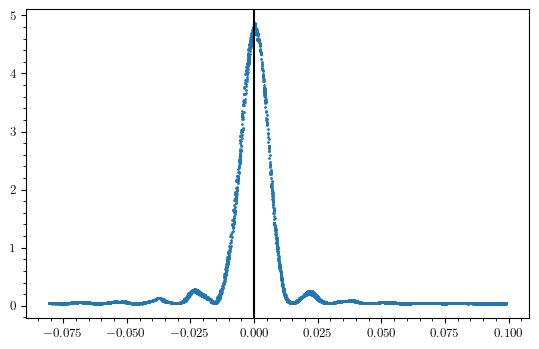

In [4]:
fig, ax = plt.subplots(1, 1)

df = dfs[2]
ax.scatter(df.y, df.I, s=1)

ylim = ax.get_ylim()
ax.plot([0, 0], ylim, color="black")
ax.set_ylim(ylim)

Scatter graph

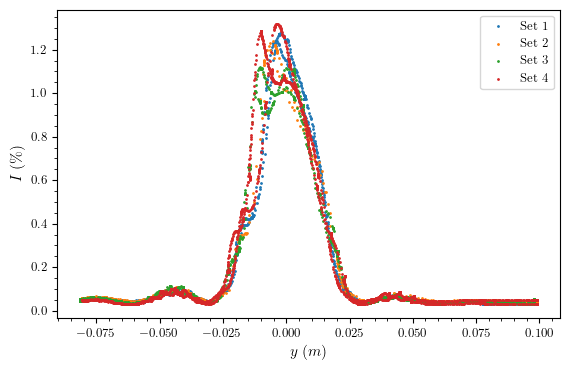

In [ ]:
fig, ax = plt.subplots(1, 1)

for i, df in enumerate(dfs):
    ax.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

ax.set_xlabel(r"$y \; (m)$")
ax.set_ylabel(r"$I \; (\%)$")
ax.legend()

fig.savefig(graph_path / f"scatter_{slit_name}.png")

Find minimums

In [ ]:
fig, ax = plt.subplots(1, 1)

for i, df in enumerate(dfs):
    ax.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

minimums = [
    [-0.0314, -0.0296],
    [-0.0160, -0.0148],
    [0.0144, 0.0154],
    [0.0288, 0.0308],
]

ylim = ax.get_ylim()
for minimum in minimums:
    ax.fill_betweenx(ylim, [minimum[0]]*2, [minimum[1]]*2, color="gold", alpha=0.5)

# ax.fill_betweenx(ylim, [-0.0314]*2, [-0.0296]*2, color="gold", alpha=0.5)
# ax.fill_betweenx(ylim, [-0.0160]*2, [-0.0148]*2, color="gold", alpha=0.5)
# ax.fill_betweenx(ylim, [0.0144]*2,   [0.0154]*2, color="gold", alpha=0.5)
# ax.fill_betweenx(ylim, [0.0288]*2,   [0.0308]*2, color="gold", alpha=0.5)
ax.set_ylim(0, 0.3)
ax.set_xlim(-0.04, 0.04)

ax.legend()

Fenditura dai minimi

In [ ]:
mins_df = pd.DataFrame({
    'y': [
        abs(min[0] + min[1]) / 2
        for min in minimums
    ],
    'dy': [
        abs(min[0] - min[1]) / 2
        for min in minimums
    ],
})

mins_df.loc[[0, 3], :] /= 2

mins_df['a'] =  mins_df.apply(lambda r: wave_length * distance / r.y, axis=1)
mins_df['da'] =  mins_df.apply(lambda r: np.sqrt(
    (1e-3 / distance)**2 + ((r.dy + 1e-3) / r.y)**2
) * r.a, axis=1)
mins_df['w'] = mins_df.da.to_numpy()**-2

print(
    np.average(mins_df.a, weights=mins_df.w),
    1 / np.sqrt(np.sum(mins_df.w))
)

pd.options.display.float_format = '{:.10f}'.format
mins_df

2.0874831039541094e-05 9.011227147888873e-07


,y,dy,a,da,w
0,0.0306500000,0.0011500000,0.0000208891,0.0000014655,465644911398.1952514648
1,0.0313000000,0.0023000000,0.0000204553,0.0000021567,214985925496.3891601562
2,0.0303500000,0.0023500000,0.0000210956,0.0000023286,184420525333.8843688965
3,0.0305000000,0.0014000000,0.0000209918,0.0000016520,366442142672.6848144531


Fit

In [ ]:
I_expr = s('I_0') * sp.Pow( sp.sinc(
    sp.pi * s('a') / s(r'\lambda') * s('y')/s('L')
), 2) + s('c')

I_fit = sp.lambdify(
    [s('y'), s('I_0'), s('a'), s('c')],
    I_expr.evalf(
        subs = {
            s(r'\lambda'): wave_length,
            s('L'): distance,
        }
    )
)

I_expr

I_0*sinc(pi*a*y/(L*\lambda))**2 + c

Rumore e picco

In [ ]:
I_max = 1
I_min = 1

for df in dfs:
    I_min = df.I.min() if df.I.min() < I_min else I_min
    I_max = df.I.max() if df.I.max() > I_max else I_max

I_max, I_min

(4.86054993, 0.02838135)

In [ ]:
I_fitted, a_fitted, c_fitted = 0, 0, 0
for df in dfs:
    popt, pcov = curve_fit(I_fit, df.y, df.I, [I_max, slit, I_min])
    print(popt)
    I_fitted += popt[0]
    a_fitted += popt[1]
    c_fitted += popt[2]

I_fitted /= len(dfs)
a_fitted /= len(dfs)
c_fitted /= len(dfs)

print(I_fitted)
print(a_fitted)
print(c_fitted)

[4.46405332e+00 4.46383939e-05 3.40932362e-02]
[4.15076980e+00 4.25307639e-05 3.70952469e-02]
[4.63772292e+00 4.42491452e-05 3.50456184e-02]
4.417515347538461
4.3806100980715855e-05
0.035411367157445896


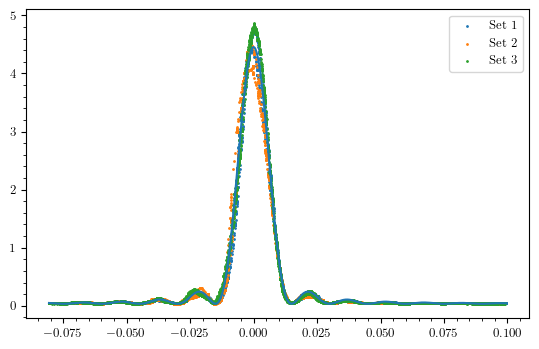

In [ ]:
fig, ax = plt.subplots(1, 1)

for i, df in enumerate(dfs):
    ax.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

x = np.linspace(
    min([
        df.y.min()
        for df in dfs
    ]),
    max([
        df.y.max()
        for df in dfs
    ]),
    1000
)

ax.plot(x, I_fit(x, I_fitted, a_fitted - 0.1e-5, c_fitted))
# ax.plot(x, I_fit(x, I_fitted + 0.3, a_fitted - 0.3e-5, c_fitted))
# ax.plot(x, I_fit(x, I_fitted - 0.3, a_fitted + 0.1e-5, c_fitted))

ax.legend()